## PROGETTO SPAM DETECTION
### L'azienda ProfessionAI vuole realizzare una libreria capace di fare analisi delle email ricevute.
### Nello specifico, il CEO ha richiesto di identificare le email di tipo SPAM sulle quali fare analisi contenutistiche.
### Il CTO nello specifico ti fornisce un dataset e ti chiede di:
### - Addestrare un classificatore per identificare SPAM
### - Individuare i Topic principali tra le email SPAM presenti nel dataset
### - Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.
### - Estrarre dalle mail NON SPAM le Organizzazioni presenti.

#Importiamo i moduli e le librerie

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import spacy
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import gensim
import gensim.corpora as corpora
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity



In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Analisi esplorativa del dataset

In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/ProfAI/natural-language-processing/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv')

In [ ]:
dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [ ]:
dataset.shape

(5171, 4)

Il dataset è composto da 5171 righe e 4 colonne. Vediamo la distribuzione delle etichette

SPAM: 1499 , 29 %
 HAM: 3672 , 71 %


<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x7f03beda83d0>,
 [Text(0, 0, 'spam'), Text(1, 0, 'ham')])

Text(0, 0.5, 'frequency')

Text(0.5, 0, 'label')

Text(0.5, 1.0, 'email ricevute')

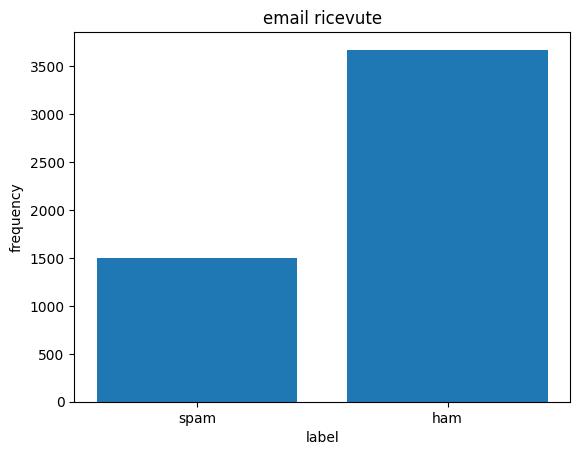

In [ ]:

tot=len(dataset)
spam=len(dataset[dataset["label_num"]==1])
ham=len(dataset[dataset["label_num"]==0])
perc_ham=(round(ham/tot*100))
perc_spam=(round(spam/tot*100))
print("SPAM:", spam ,",", perc_spam,"%\n","HAM:", ham,",", perc_ham,"%")


label = ["spam", "ham"]
popolazione = [spam,ham]
x_pos = np.arange(len(label))
plt.bar(x_pos, popolazione, align='center')
plt.xticks(x_pos, label)
plt.ylabel('frequency')
plt.xlabel('label')
plt.title('email ricevute')
plt.show()

Il dataset è fortemente sbilanciato. Abbiamo solo il 29% di email classificate come spam. Verifico se ci sono valori mancanti o duplicati

In [ ]:
missing_values_count = dataset.isna().sum()
print(missing_values_count)

duplicate_rows = dataset.duplicated()
num_duplicates = duplicate_rows.sum()
print(f"Numero di righe duplicate: {num_duplicates}")

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64
Numero di righe duplicate: 0


Non ci sono valori mancanti o duplicati

#Preprocessing

 - Effettuo la pulizia del dataset tramite la funziona data_cleaner() che include rimozione punteggiature,lemming, stemming, lemmatization e rimozione stopwords e numeri.
 - Definisco X e y e suddivido il dataset in train e test set.
 - Effettuo la vettorizzazione tramite la funzione bow_tfidf().La vettorizzazione viene applicata separatamente ai set di addestramento e di test. Durante la vettorizzazione, si adattano i parametri solo sul set di addestramento e poi si trasformano sia il set di addestramento che quello di test. Questo garantisce che le caratteristiche estratte dal set di test non influenzino il modello durante l'addestramento.


In [ ]:
english_stopwords = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)


def data_cleaner(sentence):
    sentence = str(sentence).lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)
    return sentence

# Applicazione della funzione al DataFrame
dataset['cleaned_text'] = dataset['text'].apply(data_cleaner)

In [ ]:
dataset.head()


,Unnamed: 0,label,text,label_num,cleaned_text
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0,subject enron methanol meter follow note I gi...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,subject hpl nom january see attached file hp...
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,subject neon retreat ho ho ho around wonderful...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop window office cheap main tre...
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0,subject indian spring deal book teco pvr reven...


In [ ]:
dataset['cleaned_text'] = dataset['cleaned_text'].astype(str)

#definisco X e y
X=dataset["cleaned_text"]
y=dataset["label_num"]


# Suddivisione in Train e Test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)



In [ ]:
def bow_tfidf(dataset, tfidf_vectorizer=None):
    if tfidf_vectorizer is None:
        tfidf_vectorizer = TfidfVectorizer()
        X = tfidf_vectorizer.fit_transform(dataset)
    else:
        X = tfidf_vectorizer.transform(dataset)

    return X.toarray(), tfidf_vectorizer

# Vettorizzazione del set di addestramento
X_train_vector, tfidf_vectorizer = bow_tfidf(X_train)

# Vettorizzazione del set di test utilizzando il vettorizzatore già addestrato
X_test_vector, _ = bow_tfidf(X_test, tfidf_vectorizer)

In [ ]:
X_train_vector
X_test_vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#1)Addestrare un classificatore per identificare SPAM



 Inizio con modelli semplici come la logistic regression.

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vector, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#creo funzione evaluate_model() per la valutazione del modello

def evaluate_model(model,data):
  X,y=data
  y_pred = model.predict(X)
  report=classification_report(y_pred,y)
  cm=confusion_matrix(y_pred,y)
  print(report, cm)

In [ ]:
evaluate_model (lr,(X_train_vector, y_train))
evaluate_model (lr,(X_test_vector, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2910
           1       1.00      0.98      0.99      1226

    accuracy                           1.00      4136
   macro avg       1.00      0.99      0.99      4136
weighted avg       1.00      1.00      1.00      4136
 [[2910    0]
 [  20 1206]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       731
           1       0.99      0.95      0.97       304

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.98      1035
weighted avg       0.98      0.98      0.98      1035
 [[727   4]
 [ 15 289]]


Nonostante lo sbilanciamento delle classi, il modello performa già benissimo. Vediamo con un modello MLP.

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic',
                    hidden_layer_sizes=(100,),
                    max_iter=100,
                    solver='adam',
                    tol=0.005,
                    verbose=True)

clf.fit(X_train_vector, y_train)

Iteration 1, loss = 0.59554566
Iteration 2, loss = 0.55990712
Iteration 3, loss = 0.52230121
Iteration 4, loss = 0.48002407
Iteration 5, loss = 0.42984577
Iteration 6, loss = 0.37285338
Iteration 7, loss = 0.31471597
Iteration 8, loss = 0.26118415
Iteration 9, loss = 0.21524367
Iteration 10, loss = 0.17823475
Iteration 11, loss = 0.14880895
Iteration 12, loss = 0.12560638
Iteration 13, loss = 0.10740174
Iteration 14, loss = 0.09284232
Iteration 15, loss = 0.08118343
Iteration 16, loss = 0.07166819
Iteration 17, loss = 0.06382944
Iteration 18, loss = 0.05731681
Iteration 19, loss = 0.05182192
Iteration 20, loss = 0.04723670
Iteration 21, loss = 0.04327728
Iteration 22, loss = 0.03986841
Iteration 23, loss = 0.03693475
Iteration 24, loss = 0.03438888
Iteration 25, loss = 0.03211608
Iteration 26, loss = 0.03014171
Iteration 27, loss = 0.02840005
Iteration 28, loss = 0.02681852
Iteration 29, loss = 0.02543169
Iteration 30, loss = 0.02416509
Training loss did not improve more than tol=0.005

MLPClassifier(activation='logistic', max_iter=100, tol=0.005, verbose=True)

In [ ]:
print("TRAIN set")
evaluate_model (clf,(X_train_vector, y_train))
print("TEST set")
evaluate_model (clf,(X_test_vector, y_test))

TRAIN set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2929
           1       1.00      1.00      1.00      1207

    accuracy                           1.00      4136
   macro avg       1.00      1.00      1.00      4136
weighted avg       1.00      1.00      1.00      4136
 [[2929    0]
 [   1 1206]]
TEST set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       741
           1       0.98      0.97      0.97       294

    accuracy                           0.99      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.99      0.99      0.99      1035
 [[734   7]
 [  8 286]]


In [ ]:
# prendiamo ad esempio la riga 22 del dataset ripulito e vediamo se la predizione è corretta
label_22=dataset['label'][22]
print("label:", label_22)


text_to_predict = dataset['cleaned_text'][22]
text_vector, _ = bow_tfidf([text_to_predict], tfidf_vectorizer)

# Make the prediction
target = clf.predict(text_vector)
if target == 0:
  print("prediction: ham")
else:
  print("prediction: spam")



label: ham
prediction: ham


Anche in questo caso le performance sono ottime. Il modello riesce bene a distinguere tra spam e ham.

#2) Individuare i Topic principali tra le email SPAM presenti nel dataset tramite LDA

- Filtro gli spam del dataset
- Per individuare i topic creiamo il dizionario e il corpus tramite doc2bow() che verrà utilizzato dal modello LDA.
- Al fine di identificare i topic di maggior rilevanza, utilizzo Counter() per aggregare le probabilità dei topic per ciascun documento nel corpus generato dal modello LDA e il metodo most_common() dell'oggetto Counter, che restituisce una lista delle N tuple (topic_id, count) più comuni.

In [ ]:
spam_data = dataset[dataset['label'] == "spam"]
spam_data

,Unnamed: 0,label,text,label_num,cleaned_text
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop window office cheap main tre...
7,4185,spam,Subject: looking for medication ? we ` re the ...,1,subject look medication good source difficult ...
10,4922,spam,Subject: vocable % rnd - word asceticism\nvcsc...,1,subject vocable rnd word asceticism vcsc brand...
11,3799,spam,Subject: report 01405 !\nwffur attion brom est...,1,subject report wffur attion brom est inst siu...
13,3948,spam,Subject: vic . odin n ^ ow\nberne hotbox carna...,1,subject vic odin n ow berne hotbox carnal brid...
...,...,...,...,...,...
5159,4381,spam,Subject: pictures\nstreamlined denizen ajar ch...,1,subject picture streamline denizen ajar chase ...
5161,4979,spam,Subject: penny stocks are about timing\nnomad ...,1,subject penny stock time nomad international i...
5162,4162,spam,Subject: anomaly boys from 3881\nuosda apaprov...,1,subject anomaly boy uosda apaprove mledms heu...
5164,4365,spam,Subject: slutty milf wants to meet you\ntake t...,1,subject slutty milf want meet take ilaa liqaa


In [ ]:
spam_data.shape

(1499, 5)

In [ ]:
# Trasforma i documenti in liste di parole
data_words = [doc.split() for doc in spam_data['cleaned_text']]

# Crea il dizionario
id2word = corpora.Dictionary(data_words)

# Crea il corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

In [ ]:
#LDA model
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       passes = 20)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"I" + 0.018*"nbsp" + 0.013*"subject" + 0.007*"e" + 0.006*"http" + '
  '0.006*"r" + 0.005*"com" + 0.005*"email" + 0.005*"time" + 0.004*"c"'),
 (1,
  '0.008*"cd" + 0.005*"subject" + 0.004*"pro" + 0.004*"microsoft" + '
  '0.003*"sofftwaare" + 0.002*"xp" + 0.002*"I" + 0.002*"title" + 0.002*"e" + '
  '0.002*"get"'),
 (2,
  '0.004*"subject" + 0.003*"waste" + 0.003*"leth" + 0.002*"million" + '
  '0.002*"per" + 0.002*"word" + 0.002*"http" + 0.002*"I" + 0.002*"tirr" + '
  '0.002*"biosphere"'),
 (3,
  '0.013*"price" + 0.011*"adobe" + 0.011*"window" + 0.009*"software" + '
  '0.009*"professional" + 0.009*"xp" + 0.007*"office" + 0.007*"microsoft" + '
  '0.006*"ms" + 0.005*"photoshop"'),
 (4,
  '0.010*"subject" + 0.004*"rnd" + 0.003*"I" + 0.003*"b" + 0.003*"alt" + '
  '0.003*"info" + 0.002*"med" + 0.002*"get" + 0.002*"time" + 0.002*"http"'),
 (5,
  '0.017*"subject" + 0.013*"com" + 0.011*"I" + 0.009*"http" + 0.008*"www" + '
  '0.008*"get" + 0.007*"e" + 0.006*"computron" + 0.006*"price" 

Gli spam sono stati suddivisi in 10 topic. Vediamo quali sono i topic più coerenti

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence_per_topic()


print("Coherence per topic:")
for topic_num, topic_coherence in enumerate(coherence_lda):
    print(f"Topic {topic_num}: {topic_coherence}")


Coherence per topic:
Topic 0: 0.43487519512943945
Topic 1: 0.5377494532894193
Topic 2: 0.36566256777336636
Topic 3: 0.768907154416627
Topic 4: 0.3800901350960682
Topic 5: 0.6747577019680124
Topic 6: 0.4983728519882152
Topic 7: 0.6756007803827371
Topic 8: 0.330490783803953
Topic 9: 0.8367182805166429


Selezioni i topic con una coerenza del 60%

In [ ]:
topic_coherent=[]
for topic_num, topic_coherence in enumerate(coherence_lda):
  if topic_coherence > 0.6:
    topic_coherent.append(topic_num)
    print(f"Topic {topic_num}: {topic_coherence}")


Topic 3: 0.768907154416627
Topic 5: 0.6747577019680124
Topic 7: 0.6756007803827371
Topic 9: 0.8367182805166429


I topic più coerenti sono il 3,5,7 e 9.

#3) Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.

Utilizzo il word embedding per calcolare il vettore medio per ciascun topic.Successivamente calcolo le distanze semantiche tra i vettori medi dei topics utilizzando cosine_similarity().

In [ ]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
from scipy.spatial.distance import cosine

# Funzione per calcolare il vettore medio
def avg_vector(words, glove_vectors):
    vector = np.zeros(300)
    valid_words = [word for word in words if word in glove_vectors.key_to_index]
    if not valid_words:
        return vector
    for word in valid_words:
        vector += glove_vectors.get_vector(word)
    return vector / len(valid_words)

# Calcolo il vettore medio per ciascun topic selezionato
topic_vectors = []
for topic_id in topic_coherent:
    # Ottiengo le parole chiave per ciascun topic
    topic_words = [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
    # Calcolo il vettore medio delle parole chiave
    topic_vector = avg_vector(topic_words, glove_vectors)
    topic_vectors.append((topic_id, topic_vector))


In [ ]:
topic_vectors

[(3,
  array([-0.2395839 ,  0.0100742 ,  0.0438268 , -0.24729251, -0.074199  ,
          0.12510547, -0.41550588,  0.03856841,  0.0632894 , -0.851641  ,
          0.0873406 ,  0.3103072 ,  0.3826995 , -0.34019629, -0.12964921,
          0.1106661 ,  0.0124991 , -0.14000208,  0.16167764, -0.0779365 ,
          0.295454  , -0.0959458 ,  0.0976001 , -0.02572003, -0.0650495 ,
          0.1839963 ,  0.011098  ,  0.0514696 , -0.06980594,  0.0105832 ,
          0.0458059 ,  0.2842043 ,  0.18755349,  0.11861148, -0.424535  ,
         -0.0092904 , -0.3059943 , -0.0887781 , -0.14166929, -0.2673655 ,
         -0.0262424 ,  0.261073  , -0.1583488 ,  0.487501  , -0.0686314 ,
          0.0455777 ,  0.211596  ,  0.0088219 , -0.09329785, -0.4648903 ,
          0.1032628 , -0.1041803 ,  0.2054715 ,  0.10244169,  0.0357539 ,
          0.175111  ,  0.1177242 , -0.064136  , -0.12177683,  0.01600887,
          0.29069479,  0.1617359 ,  0.331959  ,  0.0843023 ,  0.09856257,
         -0.016189  , -0.05345197

Calcolo della matrice di similarità coseno tra i vettori dei topic

In [ ]:
# Verifica e conversione di topic_vectors in una matrice numpy
topic_vectors_np = np.array([vector for _, vector in topic_vectors])

# Calcolo della matrice di similarità coseno tra i vettori dei topic
similarity_matrix = cosine_similarity(topic_vectors_np)

# Calcolo della matrice di distanza utilizzando 1 - similarità coseno
distance_matrix = 1 - similarity_matrix
np.set_printoptions(suppress=True)


In [ ]:
# Creazione del DataFrame con gli indici dei topic
topic_labels = [f"Topic {idx}" for idx, _ in topic_vectors]
df_distance_matrix = pd.DataFrame(distance_matrix, index=topic_labels, columns=topic_labels)

# Visualizzazione del DataFrame
print("Matrice di similarità semantica tra i topic")
print(df_distance_matrix)

Matrice di similarità semantica tra i topic
         Topic 3  Topic 5  Topic 7  Topic 9
Topic 3     0.00     0.54     0.54     0.69
Topic 5     0.54    -0.00     0.50     0.62
Topic 7     0.54     0.50     0.00     0.78
Topic 9     0.69     0.62     0.78     0.00


#4) Estrarre dalle mail NON SPAM le Organizzazioni presenti.

Filtro gli ham del dataset ed estraggo le ORG nella lista organizations

In [ ]:
ham_data = dataset[dataset['label'] == "ham"]
ham=ham_data["cleaned_text"]


# Estrarre le organizzazioni dalle email non spam
organizations = []

for sentence in ham:
    doc = nlp(sentence)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            organizations.append(ent.text)




In [ ]:
# Rimuovere duplicati e visualizzare le organizzazioni estratte
unique_organizations = set(organizations)
print("Organizzazioni trovate nelle email non spam:")
unique_organizations


Organizzazioni trovate nelle email non spam:


{'den washington national dc dca  ',
 'subject fw statement',
 'thompson corp enron enron',
 'gore corp enron enron',
 'enron enron bill berkeland corp enron enron joe parks corp enron enron',
 'jackson plea',
 'houston base enron',
 'shannon corp eddie',
 'subject union carbide',
 'devon',
 'coastal',
 'texas calgary',
 'rockefeller',
 'hyatt regency hill',
 'n  kdl',
 'texas gulf',
 'nsf htmlmedia',
 'north america corp yvette',
 'enron sr specialist position group',
 'enron warn',
 'supreme court',
 'subject fw fw fw dance select',
 'fidelity freedom fund fund remain',
 'pat clyne corp enron enron daren',
 'southern union company h gas company inc texas',
 'america corp victor',
 'texas logistics',
 'new orleans inc     ',
 'wendy barbour canada  craig h  kathy',
 'apache corp   ',
 'florida mobil street',
 'enron corp chapter',
 'workbench magazine kit jig tool',
 'modem special edition',
 'dan hyvl',
 'edi impact',
 'mci',
 'exxon reconcile',
 'tenaska',
 'justin',
 'k smith glori